### Imports

In [1]:
import sys
sys.path.insert(0, 'D:\Workspace\workspace_masterarbeit\PainLevelShiftDetection\Classes')

import warnings
warnings.filterwarnings('ignore')

from models import ClassificationModel, EmbeddingsModel, SiameseModel
from trainer import SiameseTrainerCombinationDataset, all_subjects_intense

import torch
import json
import numpy as np
import csv
from tqdm import tqdm


### Set Hyperparameters

In [115]:
subjects_test = all_subjects_intense[8:9]
subjects_train = [sub for sub in all_subjects_intense if sub not in subjects_test]

In [198]:
trainer_hyperparameter = {
    "path": "D:\Workspace\workspace_masterarbeit\PainLevelShiftDetection\FeatureGeneration\dataset_processed\INTENSE\\normalized_subjects_no_outliner.pkl",
    "subjects_train": subjects_train,
    "subjects_test": subjects_test,
    "wandb": False,
    "log": True,
    "learning_rate": 0.001,
    "batch_size": 256,
    "batch_size_test": 256,
    "freeze_embed": False,
    "dataset_ignore_subject_train": True,
    "dataset_ignore_subject_test": False,
    "decision_function": 1,
    "filter": [],
    "weight_decay": 0.0001,
    "lr_steps": 5,
    "adam": True,
    "number_steps": None,
    "number_steps_testing": None,
    "number_steps_histogramm": None
}

model_embedding_hyperparameter = {
        "sigmoid": False,
        "dropout": 0.35,
        "layers": [207, 512, 64]
}

model_classifier_hyperparameter = {
    "dropout": 0.35,
    "layers": [1]
}

### Init models

In [199]:
classifier_model = ClassificationModel(model_classifier_hyperparameter)
embedding_model = EmbeddingsModel(model_embedding_hyperparameter)

siamese_model = SiameseModel(embedding_model, classifier_model, decision_function=trainer_hyperparameter["decision_function"])

# #
#  0 = abs(sub())
#  1 = euclid
#  2 = cos_simil
# #

In [200]:
trainer = SiameseTrainerCombinationDataset(trainer_hyperparameter, siamese_model, device="cuda:0")

### start training

In [201]:
subjects_test

['21']

In [202]:
trainer.trainloop(20)

epoch: 1 | train_acc: 0.4977 | test_acc: 0.5333
epoch: 2 | train_acc: 0.4981 | test_acc: 0.5778
epoch: 3 | train_acc: 0.5067 | test_acc: 0.5333
epoch: 4 | train_acc: 0.4923 | test_acc: 0.5778
epoch: 5 | train_acc: 0.4942 | test_acc: 0.5333
epoch: 6 | train_acc: 0.4964 | test_acc: 0.5556
epoch: 7 | train_acc: 0.5028 | test_acc: 0.5556
epoch: 8 | train_acc: 0.5065 | test_acc: 0.5333
epoch: 9 | train_acc: 0.5081 | test_acc: 0.5778
epoch: 10 | train_acc: 0.5033 | test_acc: 0.6
epoch: 11 | train_acc: 0.4937 | test_acc: 0.5778
epoch: 12 | train_acc: 0.4958 | test_acc: 0.5556
epoch: 13 | train_acc: 0.4959 | test_acc: 0.5556
epoch: 14 | train_acc: 0.5026 | test_acc: 0.5333
epoch: 15 | train_acc: 0.5018 | test_acc: 0.5556
epoch: 16 | train_acc: 0.5085 | test_acc: 0.5556
epoch: 17 | train_acc: 0.4966 | test_acc: 0.5556
epoch: 18 | train_acc: 0.4957 | test_acc: 0.5556
epoch: 19 | train_acc: 0.5072 | test_acc: 0.5333
epoch: 20 | train_acc: 0.5098 | test_acc: 0.5556


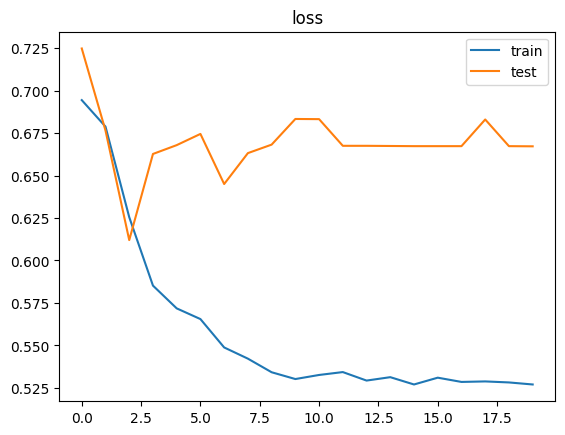

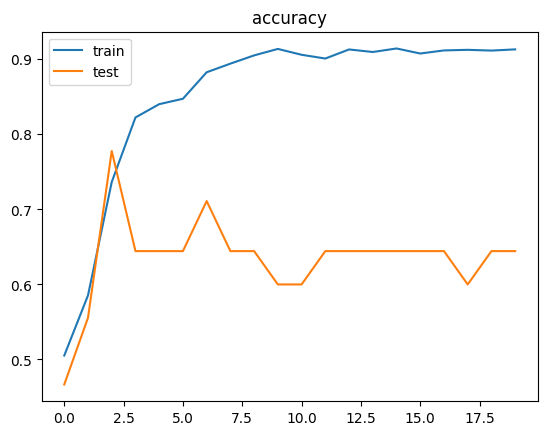

In [ ]:
trainer.plot_history()

### plot additional result data

In [184]:
best_epoch = max(trainer.history, key=lambda x:x['test_acc'])["epoch"]
cm = trainer.history_cm[best_epoch-1]["cm"]

print("acc:", trainer.history[best_epoch-1]["test_acc"])

acc: 0.7778


In [185]:
trainer.calculate_f_scores(cm)

{'recall': 0.8260869565217391, 'precision': 0.76, 'f1': 0.7916666666666667}

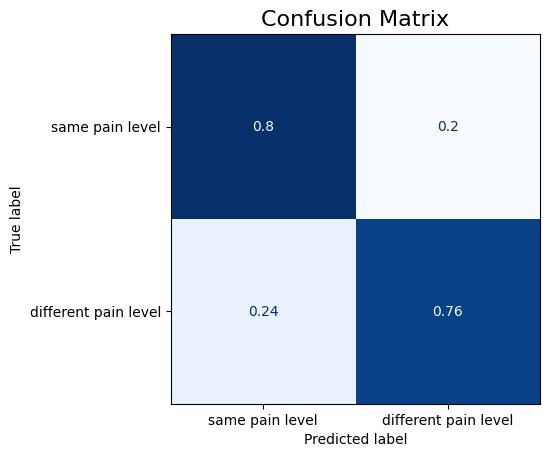

In [186]:
trainer.plot_cm(cm)

In [63]:
saving_path = "D:\Workspace\workspace_masterarbeit\PainLevelShiftDetection\SiameseNetwork\Results-LOSO\intense_distance_0.csv"

In [64]:
acc = trainer.history[best_epoch-1]["test_acc"]
results = trainer.calculate_f_scores(cm)
recall = results["recall"]
precision = results["recall"]
f1 = results["recall"]
tn = cm_normalized[0,0]
fn = cm_normalized[0,1]
fp = cm_normalized[1,0]
tp = cm_normalized[1,1]

In [65]:
with open(saving_path, mode='a') as result_file:
        results_writer = csv.writer(result_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        results_writer.writerow([subjects_test[0], acc*100, recall, precision, f1, tn, fn,fp, tp])

## LOOP

In [11]:
saving_path = "D:\Workspace\workspace_masterarbeit\PainLevelShiftDetection\SiameseNetwork\Results-LOSO\intense_distance_0_10_fold.csv"

10 fold cross validation

In [14]:
for x in tqdm(range(10)):
    subjects_test = all_subjects_intense[int(x*2.4):int((x+1)*2.4)]
    subjects_train = [sub for sub in all_subjects_intense if sub not in subjects_test]
    
    trainer_hyperparameter = {
        "path": "D:\Workspace\workspace_masterarbeit\PainLevelShiftDetection\FeatureGeneration\dataset_processed\INTENSE\\normalized_subjects_no_outliner.pkl",
        "subjects_train": subjects_train,
        "subjects_test": subjects_test,
        "wandb": False,
        "log": False,
        "learning_rate": 0.01,
        "batch_size": 256,
        "batch_size_test": 256,
        "freeze_embed": False,
        "dataset_ignore_subject_train": True,
        "dataset_ignore_subject_test": False,
        "decision_function": 0,
        "filter": [1, 2, 3, 4, 5, 6],
        "weight_decay": 0.001,
        "lr_steps": 20,
        "adam": True,
        "number_steps": 200,
        "number_steps_testing": 200,
        "number_steps_histogramm": None
    }

    model_embedding_hyperparameter = {
            "sigmoid": False,
            "dropout": 0.35,
            "layers": [207, 512, 64]
    }

    model_classifier_hyperparameter = {
        "dropout": 0.35,
        "layers": [64, 32]
    }

    classifier_model = ClassificationModel(model_classifier_hyperparameter)
    embedding_model = EmbeddingsModel(model_embedding_hyperparameter)

    siamese_model = SiameseModel(embedding_model, classifier_model, decision_function=trainer_hyperparameter["decision_function"])

    trainer = SiameseTrainerCombinationDataset(trainer_hyperparameter, siamese_model, device="cuda:0")

    trainer.trainloop(30)

    best_epoch = max(trainer.history, key=lambda x:x['test_acc'])["epoch"]
    cm = trainer.history_cm[best_epoch-1]["cm"]
    cm_normalized = cm/np.sum(cm,axis=1)

    acc = trainer.history[best_epoch-1]["test_acc"]
    results = trainer.calculate_f_scores(cm)
    recall = results["recall"]
    precision = results["recall"]
    f1 = results["recall"]
    tn = cm_normalized[0,0]
    fn = cm_normalized[0,1]
    fp = cm_normalized[1,0]
    tp = cm_normalized[1,1]

    with open(saving_path, mode='a') as result_file:
            results_writer = csv.writer(result_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            results_writer.writerow(["split_"+str(x), acc*100, recall, precision, f1, tn, fn,fp, tp])

100%|██████████| 10/10 [52:38<00:00, 315.88s/it]


LOSO

In [15]:
for subj in tqdm(all_subjects_intense):
    subjects_test = [subj]
    subjects_train = [sub for sub in all_subjects_intense if sub not in subjects_test]

    trainer_hyperparameter = {
        "path": "D:\Workspace\workspace_masterarbeit\PainLevelShiftDetection\FeatureGeneration\dataset_processed\INTENSE\\normalized_subjects_no_outliner.pkl",
        "subjects_train": subjects_train,
        "subjects_test": subjects_test,
        "wandb": False,
        "log": False,
        "learning_rate": 0.01,
        "batch_size": 256,
        "batch_size_test": 256,
        "freeze_embed": False,
        "dataset_ignore_subject_train": True,
        "dataset_ignore_subject_test": False,
        "decision_function": 2,
        "filter": [1, 2, 3, 4, 5, 6],
        "weight_decay": 0.001,
        "lr_steps": 20,
        "adam": True,
        "number_steps": 200,
        "number_steps_testing": 200,
        "number_steps_histogramm": None
    }

    model_embedding_hyperparameter = {
            "sigmoid": False,
            "dropout": 0.35,
            "layers": [207, 512, 64]
    }

    model_classifier_hyperparameter = {
        "dropout": 0.35,
        "layers": [1]
    }

    classifier_model = ClassificationModel(model_classifier_hyperparameter)
    embedding_model = EmbeddingsModel(model_embedding_hyperparameter)

    siamese_model = SiameseModel(embedding_model, classifier_model, decision_function=trainer_hyperparameter["decision_function"])

    trainer = SiameseTrainerCombinationDataset(trainer_hyperparameter, siamese_model, device="cuda:0")

    trainer.trainloop(30)

    best_epoch = max(trainer.history, key=lambda x:x['test_acc'])["epoch"]
    cm = trainer.history_cm[best_epoch-1]["cm"]
    cm_normalized = cm/np.sum(cm,axis=1)

    acc = trainer.history[best_epoch-1]["test_acc"]
    results = trainer.calculate_f_scores(cm)
    recall = results["recall"]
    precision = results["recall"]
    f1 = results["recall"]
    tn = cm_normalized[0,0]
    fn = cm_normalized[0,1]
    fp = cm_normalized[1,0]
    tp = cm_normalized[1,1]

    with open(saving_path, mode='a') as result_file:
            results_writer = csv.writer(result_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            results_writer.writerow([subj, acc*100, recall, precision, f1, tn, fn,fp, tp])

100%|██████████| 24/24 [1:50:11<00:00, 275.49s/it]
